In [1]:
import torch
import numpy as np
import pandas as pd
from scipy.ndimage import binary_opening, binary_closing

In [2]:
def correct(y, size=10):
    struct = np.ones(size, dtype=bool)
    closed = binary_closing(y == 1, structure=struct)  # 1. Merge events separated by short gaps
    opened = binary_opening(closed, structure=struct)  # 2. Remove events that are too short
    corrected = opened.astype(int)
    return corrected

def to_event_list(event_or_not):
    last = 0
    events = []
    current_event = {}
    for i, current in enumerate(event_or_not):
        current = current.item()
        if current == last:
            continue

        if current > last:  # Beginning of a new event
            current_event['start'] = i
            last = current
            continue

        if current < last:  # End of the new event
            current_event['end'] = i
            last = current
            events.append(current_event)
            current_event = {}
            continue
    return events

def do_overlap(ev1, ev2):
    return ev1['end'] >= ev2['start'] and ev1['start'] <= ev2['end']

def calc_metrics(y_true_list, y_pred_list):
    TPs = []
    for i, event_pred in enumerate(y_pred_list):
        for j, event_true in enumerate(y_true_list):
            if do_overlap(event_pred, event_true):
                TPs.append(i)
                del y_true_list[j]
                break
    for i in TPs[::-1]:
        del y_pred_list[i]
    TPs = len(TPs)
    FPs = len(y_pred_list)
    FNs = len(y_true_list)
    return TPs, FPs, FNs

264 264


<Axes: >

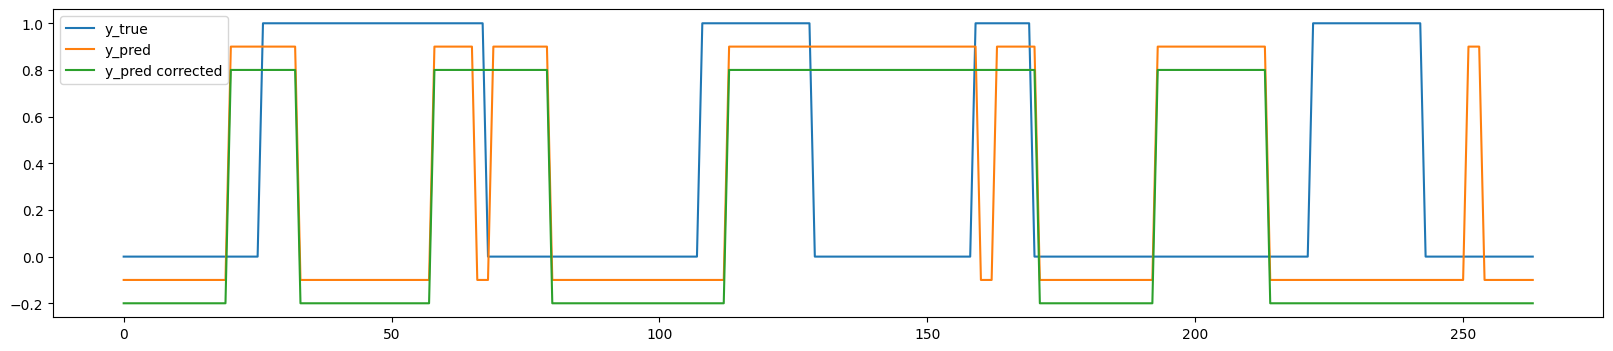

In [3]:
y_true = torch.tensor([0]*26+[1]*42+[0]*40+[1]*21+[0]*30+[1]*11+[0]*52+[1]*21+[0]*21)
y_pred = torch.tensor([0]*20+[1]*13+[0]*25+[1]*8+[0]*3+[1]*11+[0]*33+[1]*47+[0]*3+[1]*8+[0]*22+[1]*21+[0]*37+[1]*3+[0]*10)

print(len(y_true), len(y_pred))
pd.DataFrame({'y_true': y_true, 'y_pred': y_pred-.1, 'y_pred corrected': correct(y_pred)-.2}).plot(figsize=(20, 4))

In [55]:
y_true_list = to_event_list(y_true)
y_pred_list = to_event_list(correct(y_pred))
calc_metrics(y_true_list, y_pred_list)

(2, 2, 2)